In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy

In [2]:
from cov_3X2 import *
from fisher import *

In [3]:
import lsst_utils
reload(lsst_utils)
from lsst_utils import *

In [4]:
fig_home='./figures/'
fig_format='pdf'

In [5]:
def cosmo_w0_wa(cosmo=None,w0=-1,wa=0):
    attrs=['H0','Om0', 'Ode0','Tcmb0', 'Neff', 'm_nu', 'Ob0']
    args={}
    args['w0']=w0
    args['wa']=wa
    for a in attrs:
        args[a]=getattr(cosmo,a)
    cosmo_w=astropy.cosmology.w0waCDM(**args)
    return cosmo_w
cosmo_w0_wa(cosmo=cosmo)

w0waCDM(H0=67.7 km / (Mpc s), Om0=0.307, Ode0=0.691, w0=-1, wa=0, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [6]:
def cosmo_h_set(cosmo=None,cosmo_params={}):
    if cosmo_params['wa']!=0:
        cosmo=cosmo_w0_wa(cosmo=cosmo,w0=cosmo_params['w'],wa=cosmo_params['wa'])
    cosmo2=cosmo.clone(H0=cosmo_params['h']*100,
                        Om0=cosmo_params['Om'],
                       Ob0=cosmo_params['Omb'],
#                        Odm0=cosmo_params['Omd'],
#                        Ok0=cosmo_params['Omk'],
#                        w=cosmo_params['w'],
                       m_nu=[0,0,cosmo_params['mnu']]*units.eV
                    )

In [7]:
def get_x_var(x0=None,dx_max=0.01,do_log=False,Nx=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    if do_log:
        x0=np.absolute(x0)
        x_vars=x0**Dx
        if x0==1:
            x_vars=(2.**Dx)/2. # 1**x=1
        if x0==0:
            x_vars=np.logspace(-3,-2,Nx)
        x_vars*=np.sign(cosmo_fid[p])
        x_grad=np.gradient(np.log(x_vars))
    else:
        x_vars=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        if x0==0:
            x_vars=Dx-1
        x_grad=np.gradient(x_vars)
    return x_vars,x_grad

In [8]:
def fish_cosmo_model(p='As',Nx=2,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False):
    x0=cosmo_fid[p]

    models={}
    covs={}
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    print(p,x_vars)
    for i in np.arange(Nx):
        cosmo_t=cosmo_fid.copy()

        cosmo_t[p]=x_vars[i]

        if p=='s8':
            s80=cosmo_fid['s8']
            cosmo_t['As']*=(cosmo_t['s8']/s80)**2
            kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
            kappa_class.Ang_PS.PS.pk=None
            x_vars[i]=kappa_class.Ang_PS.PS.s8
#                 print(x_vars[p][i],s80,cosmo_t['s8'])
        cosmo_h2=cosmo_h_set(cosmo=cosmo,cosmo_params=cosmo_t)
        cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t,cosmo_h=cosmo_h2)
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad

In [9]:
def set_zbin_bias0(zs_bins={},bias=0):
    bias0=np.copy(zs_bins['zp_bias'])
    bias0=bias*(1+zs_bins['zp'])
    return bias0

def set_zbin_bias(zs_bins={},bias=0,bin_id=0):
    bias0=np.copy(zs_bins['zp_bias'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    bias0[np.where(idx==bin_id)]=bias
    return bias0

def set_zbin_sigma(zs_bins={},zsigma_frac=1,bin_id=0):
    zp_sigma=np.copy(zs_bins['zp_sigma'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    zp_sigma[np.where(idx==bin_id)]=zp_sigma[np.where(idx==bin_id)]*zsigma_frac
    return zp_sigma
    
def fish_z_model(p='b1',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,zs_bins_kwargs0={}):
    zs_bins_kwargs=zs_bins_kwargs0.copy()
    zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
    if 'b' in p:
        x0=0
    else:
        x0=1
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        zs_bins_t=zs_bins.copy()
        if 'B' in p:
            bias=set_zbin_bias0(zs_bins=zs_bins,bias=x_vars[i])
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        if 'b' in p:
            bin_id=np.int(p[-1])
            bias=set_zbin_bias(zs_bins=zs_bins,bias=x_vars[i],bin_id=bin_id)
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        if 'sig' in p:
            bin_id=np.int(p[-1])
            zp_sigma=set_zbin_sigma(zs_bins=zs_bins,zsigma_frac=x_vars[i],bin_id=0)
            zs_bins_kwargs['z_sigma']=zp_sigma
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        kappa_class.update_zbins(z_bins=zs_bins_i,probe='shear')
        cl0G=kappa_class.cl_tomo()
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    kappa_class.update_zbins(z_bins=zs_bins,probe='shear')
    return models,covs,x_vars,x_grad

In [26]:
def fish_galaxy_model(p='b11',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,zg_bins_kwargs0={}):
    
    z_bins=kappa_class.z_bins['galaxy']
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    if 'b' in p:
        bin_indx=np.int(p[-1])
        x0=kappa_class.z_bins['galaxy'][bin_indx][p[:-1]]
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        z_bins_t=z_bins.copy()
        if 'b' in p:
            z_bins_t[bin_indx][p[:-1]]=x_vars[i]
        
        kappa_class.update_zbins(z_bins=z_bins_t,probe='galaxy')
        cl0G=kappa_class.cl_tomo()
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    kappa_class.update_zbins(z_bins=z_bins,probe='galaxy')
    return models,covs,x_vars,x_grad    

In [27]:
def fisher_calc(cosmo_params=['As'],z_params=[],galaxy_params=[],Nx=2,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False,
               cov_3X2_kwargs={},zs_bins_kwargs={},ell_bin_kwargs={},cl0=None,priors=None):
    if kappa_class is None:
        zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
        l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
        kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
        
        cl0G=kappa_class.cl_tomo()
        cl0=cl0G['stack'].compute()
    
    cl_t=cl0 #cl0G['stack'].compute()
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    cosmo_h=kappa_class.Ang_PS.PS.cosmo_h.clone()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov

    ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)
    params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    x_grads={}
    for p in cosmo_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_cosmo_model(p=p,Nx=Nx,dx_max=dx_max,do_log=do_log,
                                                     kappa_class=kappa_class,do_cov=do_cov)
    for p in z_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_z_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,zs_bins_kwargs0=zs_bins_kwargs)
    
    for p in galaxy_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_galaxy_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,zg_bins_kwargs0=zs_bins_kwargs)
    
    for p in params_all:
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grads[p]
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grads[p]
#             print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params_all:
        i2=0
        for p2 in params_all:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            
            if do_cov:
#                 print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p_inv']=np.copy(cov_p_inv)
    if priors is not None:
        i2=0
        for p1 in params_all:
            cov_p_inv[i2,i2]+=1./priors[p1]**2
            i2+=1
    try:
        out['cov_p']=np.linalg.inv(cov_p_inv)
        out['error']=np.sqrt(np.diag(out['cov_p']))
    except Excepion as err:
        print(err)

    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['cov_inv']=cov_inv
    out['model']=models
    out['x_vars']=x_vars
    kappa_class.do_cov=do_cov0
    return out

In [28]:
def get_cl_ells(lmax_cl=5000,lmin_cl=2,Nl_bins=40):
    l0=np.arange(lmin_cl,lmax_cl)

    lmin_cl_Bins=lmin_cl+10
    lmax_cl_Bins=lmax_cl-10
    l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
    

    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    return l0,l_bins,l


In [29]:
#setup parameters
l0,l_bins,l=get_cl_ells()
lb=0.5*(l_bins[1:]+l_bins[:-1])

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [31]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=3  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=2  # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [32]:

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

sigma_gamma=0.26
area=14000
f_sky=area*d2r**2/4/np.pi

In [33]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corrs=[corr_ll] #[corr_ggl,corr_gg,corr_ll]

In [34]:
cov_3X2_kwargs={'do_cov':do_cov,'bin_cl':bin_cl,'zg_bins':zl_bins,#'l':l0,'l_bins':l_bins,
            'SSV_cov':SSV_cov,'tidal_SSV_cov':tidal_SSV,'do_xi':False,'use_window':use_window,
            'f_sky':f_sky,'sigma_gamma':sigma_gamma,'corrs':corrs,
            'do_sample_variance':do_sample_variance,'power_spectra_kwargs':{'pk_func':'class_pk'},
            'bin_xi':bin_xi}
zs_bins_kwargs={'zmin':0.3,'zmax':3,'ns0':26,'nbins':3,'z_sigma':0.05,'z_sigma_power':1,'use_window':use_window}
ell_bin_kwargs={'lmax_cl':5000,'lmin_cl':2,'Nl_bins':40}
zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
cl0G=kappa_class.cl_tomo()
cl0=cl0G['stack'].compute()

ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [35]:
priors={}
priors['As']=np.inf
priors['Om']=np.inf
priors['w']=np.inf
priors['wa']=np.inf

In [36]:
priors['B']=0.001 #bias =B*(1+z) 

for i in np.arange(10): #photo-z bias
    priors['b'+str(i)]=0.001

for i in np.arange(10):#galaxy bias
    priors['b1'+str(i)]=1
for i in np.arange(10): #galaxy bias, b2
    priors['b2'+str(i)]=1

priors['sig0']=0.1
priors['sig1']=0.1
priors['sig2']=0.1

In [23]:
crash

NameError: name 'crash' is not defined

In [24]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=['B'] #,'sig0','sig1','sig2']
fishes_zsigma_pz0_prior={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma_pz0_prior[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,priors=priors,
                                     cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)

ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
B [0.99 1.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
B [0.99 1.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


KeyboardInterrupt: 

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
fishes_zsigma_pz_prior={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma_pz_prior[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,priors=priors,
                                     cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)

In [ ]:
k=0.01
sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz_prior[k]['cov_p'][2:4,2:4]))
print(k,sn)
sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz0_prior[k]['cov_p'][2:4,2:4]))
print(k,sn)
# sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz[0.05]['cov_p'][2:4,2:4]))
print(k,sn)
sn=1./np.sqrt(np.linalg.det(fishes_zsigma[k]['cov_p'][2:4,2:4]))
print(k,sn)

In [ ]:
crash

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
#p=np.atleast_1d(['s8'])
fishes_zsigma_pz={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma_pz[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,
                                     cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma']=0.05

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=[]
#p=np.atleast_1d(['s8'])
fishes_zsigma={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,
                                  cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma']=0.05

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zsigma.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'ro')
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz0_prior[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'go')
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz_prior[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'mo')
    
    
ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$')
ax.set_ylabel('DETF')
fname='sigmaz_detf'
# fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)
# yscale('log')

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zsigma_pow={}
z_pow=[0,1,2]
for zp in z_pow:
    zs_bins_kwargs['z_sigma_power']=zp
    fishes_zsigma_pow[zp]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma_power']=1

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zsigma_pow.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pow[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$ pow')
ax.set_ylabel('DETF')
fname='sigmaz_pow_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)
# yscale('log')

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zmax={}
z_ms=[3] #[1,1.5,2,3]
for zm in z_ms:
    zs_bins_kwargs['zmax']=zm
    fishes_zmax[zm]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['zmax']=3

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zmin={}
z_ms=[0.1,0.3,0.5]
for zm in z_ms:
    zs_bins_kwargs['zmin']=zm
    fishes_zmin[zm]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['zmin']=0.3

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zmax.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zmax[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$z_{max}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='zmax_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zmin.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zmin[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$z_{min}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='zmin_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_ell={}
ells=[1000,2000,5000]
for ell in ells:
    ell_bin_kwargs['lmax_cl']=ell
    fishes_ell[ell]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
ell_bin_kwargs['lmax_cl']=5000

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_ell.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_ell[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$\ell_{max}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='ellmax_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [41]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb={}
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,10,1,5,3]#10
# nbs=np.arange(10)+1
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    fishes_nb[nb]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs)
zs_bins_kwargs['nbins']=3

ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]


In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
ax.set_xlim(1.5,11)
ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
['b{i}'.format(i=i) for i in np.arange(3)]

In [ ]:
priors

In [40]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb_pz={}
# p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,10,1,5,3]#10
# nbs=np.arange(10)+1
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    p_z=['b{i}'.format(i=i) for i in np.arange(nb)]
    fishes_nb_pz[nb]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs,priors=priors)
zs_bins_kwargs['nbins']=3

ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b1 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b1 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b2 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b3 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b4 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b5 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b6 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.0

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb_pz.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'bo')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'ro')
# xscale('log')
ax.set_xlim(1.5,11)
# ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf_pz'
# fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
zl_bins['n_bins']

In [ ]:
priors

In [37]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb_pz_3x2={}
# p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,1,5,3] #,10]
# nbs=np.arange(10)+1
cov_3X2_kwargs['corrs']=[corr_ll,corr_ggl,corr_gg]
b_z=['b1{i}'.format(i=i) for i in np.arange(zl_bins['n_bins'])]
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    p_z=['b{i}'.format(i=i) for i in np.arange(nb)]
    fishes_nb_pz_3x2[nb]=fisher_calc(cosmo_params=p,z_params=p_z,galaxy_params=b_z,
                                     do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs,priors=priors)
cov_3X2_kwargs['corrs']=[corr_ll]
zs_bins_kwargs['nbins']=3

ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b1 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
b10 [0.99 1.01]
b11 [0.99 1.01]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
b10 [0.9999 1.0201]
b11 [0.9999 1.0201]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b1 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b2 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b3 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.0842995

In [44]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb_pz_2x2={}
# p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,1,5,3] #,10]
# nbs=np.arange(10)+1
cov_3X2_kwargs['corrs']=[corr_ggl,corr_gg]
b_z=['b1{i}'.format(i=i) for i in np.arange(zl_bins['n_bins'])]
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    p_z=['b{i}'.format(i=i) for i in np.arange(nb)]
    fishes_nb_pz_2x2[nb]=fisher_calc(cosmo_params=p,z_params=p_z,galaxy_params=b_z,
                                     do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs,priors=priors)
cov_3X2_kwargs['corrs']=[corr_ll]
zs_bins_kwargs['nbins']=3

ns0:  23.084299523380036


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b1 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
b10 [1.03019797 1.05101005]


./galaxy_utils.py:51: RuntimeWarning: overflow encountered in multiply
  self.zg_bins[i]['nz']*=self.nz_F


b11 [1.03019797 1.05101005]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
b10 [1.04049995 1.06152015]
b11 [1.04049995 1.06152015]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.01  0.01]
ns0:  23.084299523380036
b0 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b1 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b2 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b3 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
ns0:  23.084299523380036
b4 [-0.01  0.01]
ns0:  23.084299523380036
ns0:  23.084299523380036
b10 [1.05090495 1.07213535]
b11 [1.05090495 1.07213535]
ns0:  23.084299523380036
As [2.178e-09 2.222e-09]
Om [0.304425 0.310575]
w [-0.99 -1.01]
wa [-0.

2 99.32794070178835
2 136.69071980054017
2 900.08628512081
2 731.2954841212386
1 4.222413698792374
1 4.243558029807078
1 755.331162478561
1 609.0617771677998
5 152.38012216675216
5 172.9130638692257
5 1041.3494370241983
5 840.381597901197
3 130.56495530436916
3 159.06027344339654
3 972.9563994522697
3 785.7262748022742


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


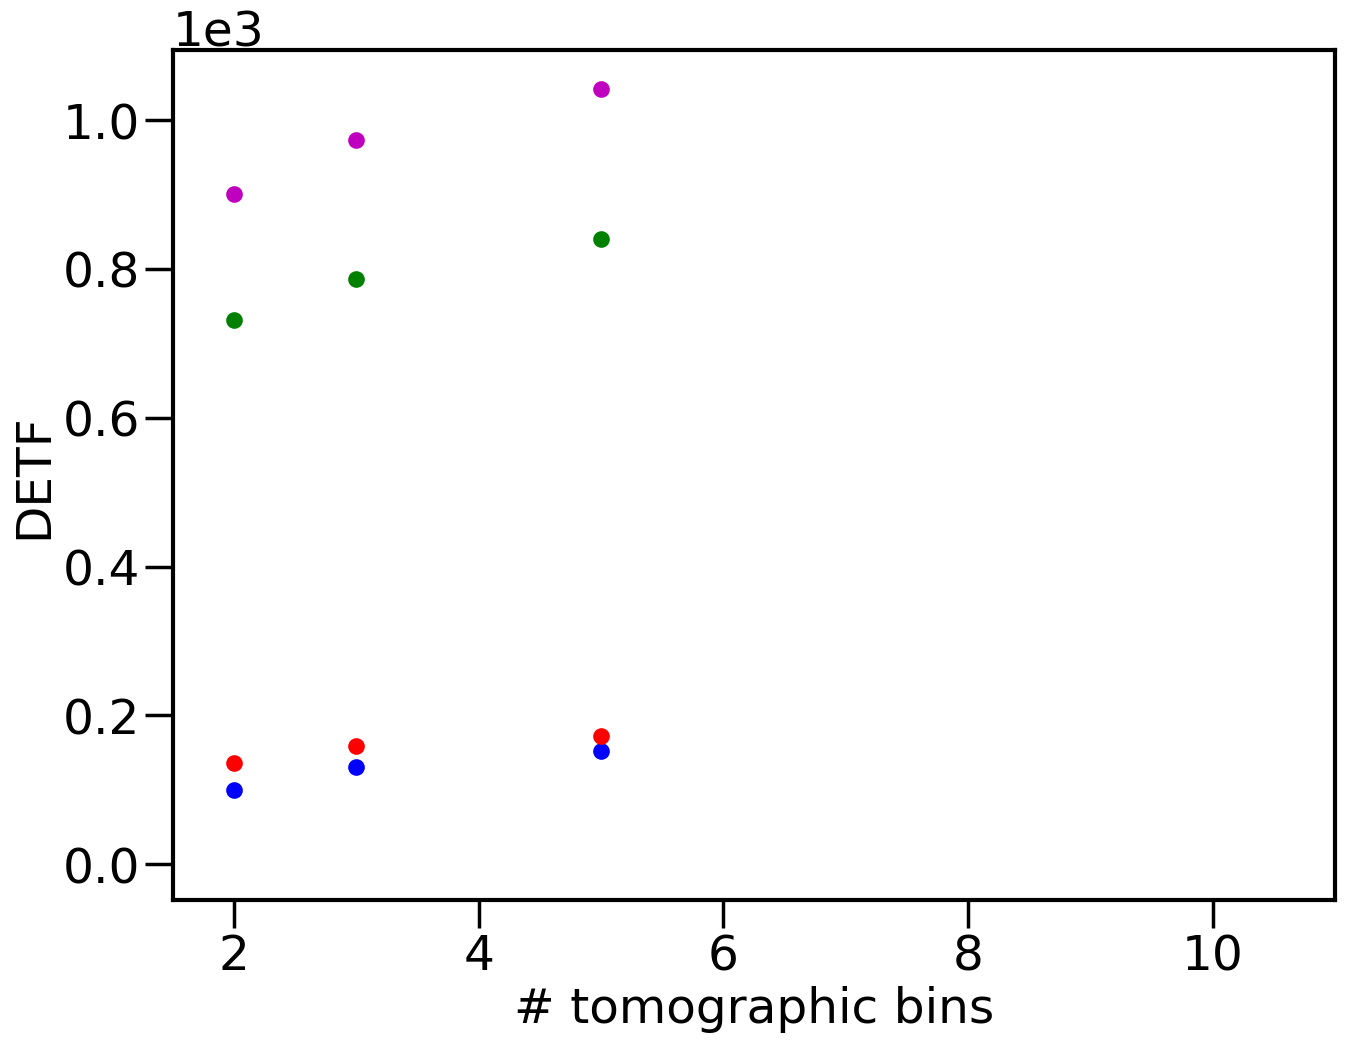

In [45]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb_pz_3x2.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'bo')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'ro')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz_3x2[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'mo')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz_2x2[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'go')

# xscale('log')
ax.set_xlim(1.5,11)
# ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf_pz'
# fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
1./np.sqrt(np.linalg.det(fish['cov_p'][-2:,-2:]))

In [ ]:
fish['error']

In [ ]:
fish['error']

In [ ]:
m=fish['model']
ci=fish['cov_inv']
np.sqrt(np.dot(m,np.dot(ci,m)))

In [ ]:
np.linalg.eig(fish['cov_p'])